<a href="https://colab.research.google.com/github/elemnurguner/data-ai-projects/blob/main/D%C3%BC%C5%9F%C3%BCk_G%C3%BC%C3%A7_T%C3%BCketimli_Model_Optimizasyonu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Düşük Güç Tüketimli Model Optimizasyonu
Google Colab'ta düşük güç tüketimli model optimizasyonu yapmak için çeşitli teknikler kullanabilirsiniz. İşte adım adım bir rehber:

1. Donanım Seçimi

In [ ]:
import tensorflow as tfs
import numpy as np

# CPU kullanacağımızı teyit edelim
print("Kullanılacak cihaz:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")



Kullanılacak cihaz: CPU


2. Hafif Model Mimarisi


In [ ]:
def create_lightweight_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(64, activation='relu'),  # Daha az nöron
        tf.keras.layers.Dropout(0.2),  # Regularization
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_lightweight_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

3. Verimli Veri Yükleme


In [ ]:
# MNIST örneği
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# CPU için daha küçük batch boyutu
batch_size = 32

# Veriyi daha hızlı işlemek için tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(1)# MNIST örneği
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# CPU için daha küçük batch boyutu
batch_size = 32

# Veriyi daha hızlı işlemek için tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


4. Model Optimizasyon Teknikleri (CPU için)
a) Quantization (Nicemleme)

In [ ]:
# Post-training quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Varsayılan optimizasyonlar
quantized_model = converter.convert()

# Quantized modeli kaydetme
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_model)

Saved artifact at '/tmp/tmp52d4d9r0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133401763085008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133401763085776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133401763085200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133401763078480: TensorSpec(shape=(), dtype=tf.resource, name=None)


b) Pruning (Budama)

In [ ]:
!pip install --upgrade tensorflow-model-optimization

In [ ]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot

print("TensorFlow version:", tf.__version__)
print("TF Model Opt version:", tfmot.__version__)

TensorFlow version: 2.18.0
TF Model Opt version: 0.8.0


In [ ]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np

# 1. Gerekli paketleri yükleme
!pip install -q tensorflow==2.18.0 tensorflow-model-optimization==0.8.0

# 2. Veri hazırlığı
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# 3. Pruning ayarları
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=0.5,
        begin_step=0,
        end_step=len(x_train)//32)
}

# 4. DOĞRU YÖNTEM: Modeli önce oluştur, sonra wrap et
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# 5. Modeli oluştur ve wrap et
model = build_model()
model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# 6. Modeli derle
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 7. Callback'ler
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tf.keras.callbacks.EarlyStopping(patience=1)
]

# 8. Modeli eğit
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

# 9. Değerlendirme
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# 10. Pruning'i kaldır ve kaydet
final_model = tfmot.sparsity.keras.strip_pruning(model)
tf.keras.models.save_model(final_model, 'pruned_model.h5')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 43.1 MB/s eta 0:00:00
Epoch 1/5
1688/1688 [==============================] - 12s 5ms/step - loss: 0.3286 - accuracy: 0.9053 - val_loss: 0.1451 - val_accuracy: 0.9600
Epoch 2/5
1688/1688 [==============================] - 9s 6ms/step - loss: 0.1758 - accuracy: 0.9483 - val_loss: 0.1119 - val_accuracy: 0.9700
Epoch 3/5
1688/1688 [==============================] - 11s 6ms/step - loss: 0.1385 - accuracy: 0.9601 - val_loss: 0.0936 - val_accuracy: 0.9742
Epoch 4/5
1688/1688 [==============================] - 10s 6ms/step - loss: 0.1156 - accuracy: 0.9658 - val_loss: 0.0877 - val_accuracy: 0.9755
Epoch 5/5
1688/1688 [==============================] - 9s 5ms/step - loss: 0.1013 - accuracy: 0.9694 - val_loss: 0.0822 - val_accuracy: 0.9750


<ipython-input-1-4d9f1ff199ec>:64: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(final_model, 'pruned_model.h5')


Test Accuracy: 0.9734


In [ ]:
!pip install --upgrade tensorflow tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 808.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorfl

1. Modelinizi Kaydetme ve Kullanma
Pruning uygulanmış modelinizi kaydedip daha sonra kullanabilirsiniz:

In [ ]:
# Pruning bilgilerini kaldır ve modeli kaydet
final_model = tfmot.sparsity.keras.strip_pruning(model)
tf.keras.models.save_model(final_model, 'pruned_mnist_model.h5')

# Modeli tekrar yükleme
loaded_model = tf.keras.models.load_model('pruned_mnist_model.h5')
loaded_model.summary()  # Model yapısını kontrol et

2. Modelinizin Neler Öğrendiğini Görselleştirme
Modelinizin doğruluğunu ve eğitim sürecini analiz edin:

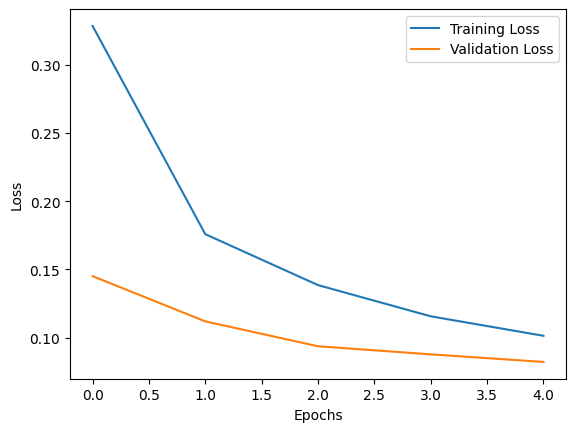

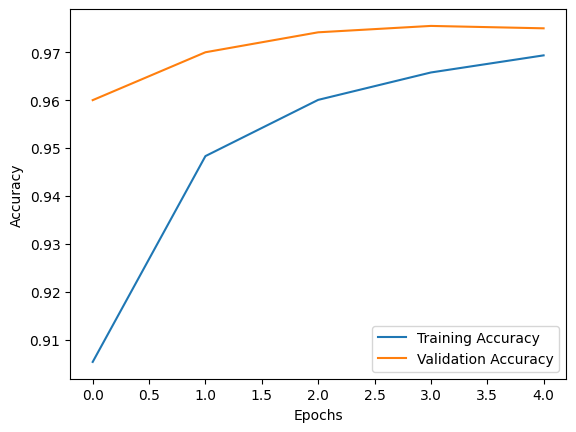

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve validation kaybını çizdir
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Doğruluk grafiği
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Bu grafikler, modelinizin overfitting olup olmadığını gösterir.

3. Modelinizi Daha da Küçültmek İçin Quantization (Nicemleme)
Pruning ile birlikte quantization uygulayarak modelinizi daha da küçültebilirsiniz

In [ ]:
# Modeli TensorFlow Lite formatına dönüştürme ve quantize etme
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Quantization uygula

quantized_model = converter.convert()

# Quantized modeli kaydet
with open('quantized_pruned_mnist.tflite', 'wb') as f:
    f.write(quantized_model)

print("Quantized model boyutu:", len(quantized_model), "bytes")

Quantized model boyutu: 105848 bytes


Bu işlem, modelinizi 4 kat daha küçük hale getirebilir (örneğin, 5MB → 1.2MB).



4. Modelinizin Pruning Sonrası Sparsity (Seyreklik) Oranını Kontrol Etme
Modelinizin ne kadar "budandığını" görmek için:

In [ ]:
for layer in final_model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        weights = layer.get_weights()[0]  # Ağırlık matrisi
        sparsity = 1.0 - np.count_nonzero(weights) / weights.size
        print(f"{layer.name} sparsity: {sparsity:.2%}")

dense sparsity: 50.00%
dense_1 sparsity: 50.00%
